In [1]:
import numpy as np
import matplotlib.pyplot as plt

# MAC0460/5832 - Lista 3: Redes Neurais - MNIST

### Data de Entrega: a definir!

##### Classificação de dígitos
Os dataset para esta tarefa foi tirado da competição do kaggle de reconhecimento de dígitos (https://www.kaggle.com/c/digit-recognizer) e está disponível em http://vision.ime.usp.br/~caiomr/mac0460_5832/train.csv.gz. O dataset está sob a licença Creative Commons Attribution-Share Alike 3.0 license (https://creativecommons.org/licenses/by-sa/3.0/). O dataset foi zipado, mas os dados estão inalterados. Cada linha (amostra) do arquivo contém 785 colunas: a primeira informa o label da amostra e as outras 784 são os valores dos pixels da imagem (28 x 28) que representa o dígito.



# Questão 1

Projete uma rede neural para resolver o problema de classificação de dígitos. Baixe o arquivo train.csv.gz (link acima) e dezipe-o para a pasta data/. Verifique que as células abaixo executam com sucesso e exibem o resultado esperado. Utilize os pacotes de python tensorflow (https://www.tensorflow.org/), theano (http://deeplearning.net/software/theano/) ou PyTorch (https://pytorch.org/) para implementar sua rede neural. Escolha o que preferir/tiver mais familiaridade - ou o quiser passar a ter mais familiaridade :) - para definir sua rede neural. Usem a arquitetura 3-layer NN 300+100 hidden units (erro 3.05%), como descrito no site http://yann.lecun.com/exdb/mnist/index.html.


Façam os três seguintes experimentos:

1. Imagem original.
2. Imagem amostrada com passo 1, isto é, reduz a imagem para 1/4 do número total de pixels.
3. Imagem amostrada com passo 2, isto é, reduz a imagem para 1/16 do número total de pixels.


Em cada experimento, execute os seguintes procedimentos:
1. Compute a curva experimental de aprendizado (N = 5000, N = 10000, N = 15000, ... N = 35000), estimar o $E_{out}$ a partir das 7000 amostras não usadas.
2. Para N = 35000 (isto é, separe 7000 amostras para validação), calcule o valor da precisão $\epsilon = E_{out} - E_{in}$.
3. Adote o valor de $\epsilon$ calculado em 2; repita dez vezes o experimento de aprendizado para $N = 35000$ e 7000 amostras de validação (em cada experimento, escolha aleatoriamente entre as 42000 amostras 7000 para formar o conjunto de validação e as restantes para treinamento); calcule o $E_{out}$ para cada um dos experimentos; a partir dos $E_{out}$ calculados, estime o valor do parâmetro $\delta$.
4. Comente os resultados obtidos.

Adote *learning rate* $\eta = 0.001$.
Para o item 3, lembre da equação $P(|E_{out}(h_{opt}) - E_{in}(h_{opt})| < \epsilon) > 1 - \delta$.

In [2]:
data = np.genfromtxt('data/train.csv', delimiter=',', skip_header=1).astype(np.dtype('uint8'))
print(data.shape)

(42000, 785)


Label:  1


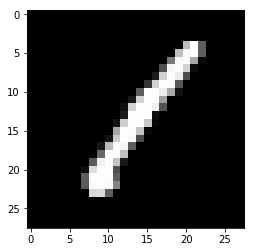

Label:  0


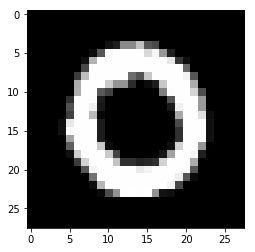

Label:  8


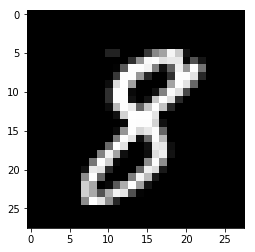

In [3]:
sample = data[0]
print("Label: ", sample[0])
plt.imshow(sample[1:].reshape((28,28)), cmap='gray')
plt.show()

sample = data[1]
print("Label: ", sample[0])
plt.imshow(sample[1:].reshape((28,28)), cmap='gray')
plt.show()

sample = data[20]
print("Label: ", sample[0])
plt.imshow(sample[1:].reshape((28,28)), cmap='gray')
plt.show()

In [4]:
data[:, :1].shape

(42000, 1)

In [150]:
import torch
import seaborn as sns
import torch.nn.functional as F
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler
import warnings
warnings.filterwarnings('ignore')
sns.set()

def to_multiclass_vector(a, n_classes):
    return np.squeeze(np.eye(n_classes)[a.reshape(-1)])

def accuracy_fn(y_pred, y_true):
    y_pred = np.argmax(y_pred.data, axis=1)
    y_pred = y_pred.numpy()
    accuracy = (y_pred == np.argmax(y_true, axis=1).numpy()).sum() / float(len(y_pred))

    return accuracy

def train_nn(X, y, train_size=5000, test_size=7000, epochs=500, D_in=784, random_state=42, verbose=False):
    
    X_train, X_test, y_train, y_test = train_test_split(X, 
                                                        y, 
                                                        train_size = train_size,
                                                        test_size = test_size,
                                                        random_state = random_state)

    y_train = to_multiclass_vector(y_train, 10)
    y_test = to_multiclass_vector(y_test, 10)

    mm = MinMaxScaler((0, 255))
    X_train = mm.fit_transform(X_train)
    X_test = mm.transform(X_test)

    ss = StandardScaler()
    X_train = ss.fit_transform(X_train)
    X_test = ss.transform(X_test)

    H_1, H_2, D_out = 300, 100, 10

    X_train = torch.from_numpy(X_train)
    y_train = torch.from_numpy(y_train)

    X_test = torch.from_numpy(X_test)
    y_test = torch.from_numpy(y_test)

    X_train, y_train = X_train.type(torch.FloatTensor), y_train.type(torch.LongTensor)
    X_test, y_test = X_test.type(torch.FloatTensor), y_test.type(torch.LongTensor)

    model = torch.nn.Sequential(
        torch.nn.Linear(D_in, H_1),
        torch.nn.ReLU(),
        torch.nn.Linear(H_1, H_2),
        torch.nn.ReLU(),
        torch.nn.Linear(H_2, D_out),
        torch.nn.Softmax(),
    )


    #loss_fn = torch.nn.MultiLabelSoftMarginLoss()
    loss_fn = torch.nn.CrossEntropyLoss()

    learning_rate = 1e-3
    test_errors = []
    train_errors = []
    optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9)
    
    for t in range(epochs):
        #for i in range(0, len(X_train), N):
        X = X_train#[i:i + N]
        y = y_train#[i:i + N]
        y_pred = model(X)
        loss = loss_fn(y_pred, torch.max(y, 1)[1])

        # Train accuracy
        y_pred = model(X_train)
        train_accuracy = accuracy_fn(y_pred, y_train)
        train_errors.append(1 - train_accuracy)
        # Test accuracy
        y_pred = model(X_test)
        test_accuracy = accuracy_fn(y_pred, y_test)
        test_loss = loss_fn(y_pred, torch.max(y_test, 1)[1])
        error = 1 - test_accuracy    
        test_errors.append(error)
        if t % 2 == 0 and verbose:
            print("{}: train loss: {:.5f}, test loss: {:.5f}, error: {:.5f}".format(t, loss.item(), test_loss.item(), error))
            #print("{}: train accuracy: {:.5f}, test accuracy: {:.5f}".format(t, train_accuracy, test_accuracy))

        model.zero_grad()
        loss.backward()
        optimizer.step()

#         with torch.no_grad():
#             for param in model.parameters():
#                 param -= learning_rate * param.grad
                
    return train_errors, test_errors

def train_size_experiment(X, y, train_sizes, epochs=5000, random_state=42, D_in=784, verbose=False):
    train_errors = []
    test_errors = []

    for train_size in train_sizes:
        print("Training with train_size of {} samples".format(train_size))
        train, test = train_nn(X, 
                               y,
                               train_size=train_size, 
                               test_size=7000,
                               epochs=epochs,
                               D_in=D_in,
                               random_state=random_state,
                               verbose=verbose)

        train_errors.append(train[-1])
        test_errors.append(test[-1])  
    
    return train_errors, test_errors

def plot_experimental_learning_curve(train_sizes, train_errors, test_errors):
    plt.figure(figsize=(12, 6))
    plt.plot([s for s in train_sizes], train_errors, label="Ein")
    plt.plot([s for s in train_sizes], test_errors, label="Eout")
    plt.legend()
    plt.xlabel("Training samples")
    plt.ylabel("Error")
    plt.title("Experimental learning curve")
    plt.show()

### Experimento 1 - Imagem original

In [ ]:
train_sizes = range(5000, 5001, 5000)
train_errors, test_errors = train_size_experiment(data[:, 1:], data[:, :1], train_sizes, epochs=8000)

Training with train_size of 5000 samples


1. Compute a curva experimental de aprendizado (N = 5000, N = 10000, N = 15000, ... N = 35000), estimar o  Eout a partir das 7000 amostras não usadas.

In [ ]:
plot_experimental_learning_curve(train_sizes, train_errors, test_errors)

2. Para N = 35000 (isto é, separe 7000 amostras para validação), calcule o valor da precisão $\epsilon = E_{out} - E_{in}$.

In [158]:
epsilon = test_errors[-1] - train_errors[-1]
print("Precisão: {}".format(test_errors[-1] - train_errors[-1]))

Precisão: 0.0002142857142857224


3. Adote o valor de $\epsilon$ calculado em 2; repita dez vezes o experimento de aprendizado para $N = 35000$ e 7000 amostras de validação (em cada experimento, escolha aleatoriamente entre as 42000 amostras 7000 para formar o conjunto de validação e as restantes para treinamento); calcule o $E_{out}$ para cada um dos experimentos; a partir dos $E_{out}$ calculados, estime o valor do parâmetro $\delta$.

In [91]:
train_sizes = 10 * [35000]
train_errors, test_errors = train_size_experiment(data[:, 1:], data[:, :1], train_sizes, epochs=30, random_state=None)

Training with train_size of 35000 samples


/opt/conda/envs/kaggle/lib/python3.7/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype uint8 was converted to float64 by MinMaxScaler.
  warnings.warn(msg, DataConversionWarning)
/opt/conda/envs/kaggle/lib/python3.7/site-packages/torch/nn/modules/container.py:91: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Training with train_size of 35000 samples
Training with train_size of 35000 samples
Training with train_size of 35000 samples
Training with train_size of 35000 samples
Training with train_size of 35000 samples
Training with train_size of 35000 samples
Training with train_size of 35000 samples
Training with train_size of 35000 samples
Training with train_size of 35000 samples


$P(|E_{out}(h_{opt}) - E_{in}(h_{opt})| < \epsilon) > 1 - \delta$.

In [99]:
delta = -1 * ((np.array(test_errors) - np.array(train_errors) < epsilon).sum() / len(test_errors) - 1)
print("Delta é maior que {}".format(delta))

Delta é maior que 0.6


### Experimento 2 - Imagem amostrada com passo 1

Isto é, reduz a imagem para 1/4 do número total de pixels.

In [125]:
data_2 = np.apply_along_axis(lambda a : a[::4], axis=1, arr=data[:, 1:])
data_2.shape

(42000, 196)

In [131]:
train_sizes = range(5000, 35001, 5000)
train_errors, test_errors = train_size_experiment(data_2, data[:, :1], train_sizes, epochs=30, D_in = 196)

Training with train_size of 5000 samples


/opt/conda/envs/kaggle/lib/python3.7/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype uint8 was converted to float64 by MinMaxScaler.
  warnings.warn(msg, DataConversionWarning)
/opt/conda/envs/kaggle/lib/python3.7/site-packages/torch/nn/modules/container.py:91: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Training with train_size of 10000 samples
Training with train_size of 15000 samples
Training with train_size of 20000 samples
Training with train_size of 25000 samples
Training with train_size of 30000 samples
Training with train_size of 35000 samples


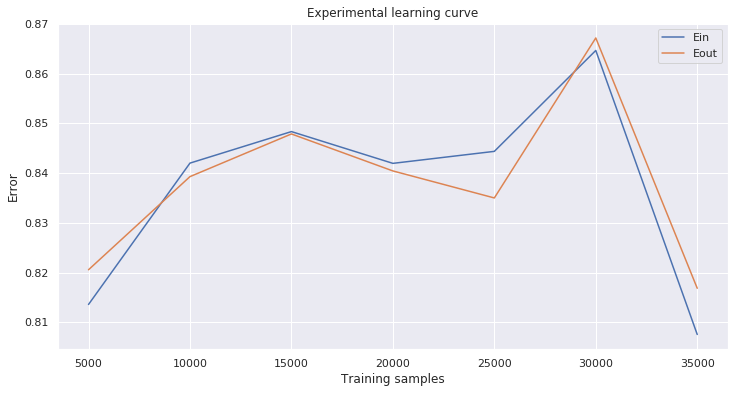

In [132]:
plot_experimental_learning_curve(train_sizes, train_errors, test_errors)

In [134]:
train_sizes = 10 * [35000]
train_errors, test_errors = train_size_experiment(data_2, data[:, :1], train_sizes, epochs=30, random_state=None, D_in = 196)

Training with train_size of 35000 samples


/opt/conda/envs/kaggle/lib/python3.7/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype uint8 was converted to float64 by MinMaxScaler.
  warnings.warn(msg, DataConversionWarning)
/opt/conda/envs/kaggle/lib/python3.7/site-packages/torch/nn/modules/container.py:91: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Training with train_size of 35000 samples
Training with train_size of 35000 samples
Training with train_size of 35000 samples
Training with train_size of 35000 samples
Training with train_size of 35000 samples
Training with train_size of 35000 samples
Training with train_size of 35000 samples
Training with train_size of 35000 samples
Training with train_size of 35000 samples


In [135]:
delta = -1 * ((np.array(test_errors) - np.array(train_errors) < epsilon).sum() / len(test_errors) - 1)
print("Delta é maior que {}".format(delta))

Delta é maior que 0.30000000000000004


### Experimento 3 - Imagem amostrada com passo 2

Isto é, reduz a imagem para 1/8 do número total de pixels.

In [141]:
data_3 = np.apply_along_axis(lambda a : a[::16], axis=1, arr=data[:, 1:])
data_3.shape

(42000, 49)

In [142]:
train_sizes = range(5000, 35001, 5000)
train_errors, test_errors = train_size_experiment(data_3, data[:, :1], train_sizes, epochs=30, D_in = 49)

Training with train_size of 5000 samples


/opt/conda/envs/kaggle/lib/python3.7/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype uint8 was converted to float64 by MinMaxScaler.
  warnings.warn(msg, DataConversionWarning)
/opt/conda/envs/kaggle/lib/python3.7/site-packages/torch/nn/modules/container.py:91: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Training with train_size of 10000 samples
Training with train_size of 15000 samples
Training with train_size of 20000 samples
Training with train_size of 25000 samples
Training with train_size of 30000 samples
Training with train_size of 35000 samples


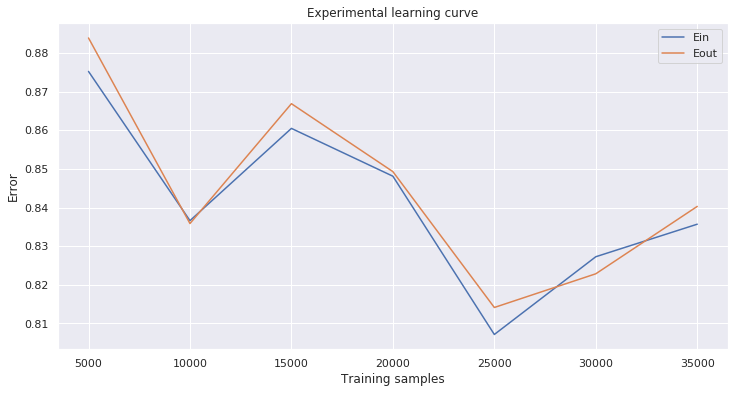

In [143]:
plot_experimental_learning_curve(train_sizes, train_errors, test_errors)

In [144]:
train_sizes = 10 * [35000]
train_errors, test_errors = train_size_experiment(data_3, 
                                                  data[:, :1],
                                                  train_sizes,
                                                  epochs=30,
                                                  random_state=None, 
                                                  D_in = 49)

Training with train_size of 35000 samples


/opt/conda/envs/kaggle/lib/python3.7/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype uint8 was converted to float64 by MinMaxScaler.
  warnings.warn(msg, DataConversionWarning)
/opt/conda/envs/kaggle/lib/python3.7/site-packages/torch/nn/modules/container.py:91: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Training with train_size of 35000 samples
Training with train_size of 35000 samples
Training with train_size of 35000 samples
Training with train_size of 35000 samples
Training with train_size of 35000 samples
Training with train_size of 35000 samples
Training with train_size of 35000 samples
Training with train_size of 35000 samples
Training with train_size of 35000 samples


In [145]:
delta = -1 * ((np.array(test_errors) - np.array(train_errors) < epsilon).sum() / len(test_errors) - 1)
print("Delta é maior que {}".format(delta))

Delta é maior que 0.4


## Comentário dos resultados:

# Questão 2

O método de aprendizado adotado na questão anterior inclui regularização? Caso afirmativo, como? Caso negativo, como formularia a inclusão da regularização e porque esse procedimento melhoraria o resultado?

**Resposta**: Não, o modelo acima foi construído sem qualquer técnica de regularização. 

Regularização é uma forma de expressar preferência por determinado tipos de solução quando trata-se de um problema de otimização. Ou seja, não se quer apenas minimizar ou maximizar uma métrica, mas se quer que a solução apresente determinadas características. 

De maneira mais objetiva, a regularização é uma ferramenta para o controle da complexidade de um modelo, tornando possível o controle do overfitting. 

No caso da rede neural podemos citar 3 formas de regularização: L1, L2 e Dropout. 